In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:
import statsmodels.stats.multitest as smm

In [2]:
df = pd.read_csv('ab_browser_test.csv')
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
df.shape

(566134, 6)

In [4]:
(sum(df[df.slot == 'exp'].n_clicks) - sum(df[df.slot == 'control'].n_clicks))*100/sum(df[df.slot == 'control'].n_clicks)

1.6135689824415806

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [6]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
exp_median_scores = list(map(np.median, get_bootstrap_samples(df[df.slot == 'exp']['n_clicks'].values, 1000)))
control_median_scores = list(map(np.median, get_bootstrap_samples(df[df.slot == 'control']['n_clicks'].values, 1000)))
print ("95% confidence interval for exp medians",  stat_intervals(exp_median_scores, 0.05))
print ("95% confidence interval for control medians",  stat_intervals(control_median_scores, 0.05))

95% confidence interval for exp medians [5. 5.]
95% confidence interval for control medians [4. 4.]


In [9]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores)))
print ("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1. -1.]


In [10]:
exp_mean_scores = list(map(np.mean, get_bootstrap_samples(df[df.slot == 'exp']['n_clicks'].values, 1000)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(df[df.slot == 'control']['n_clicks'].values, 1000)))
print ("95% confidence interval for exp means",  stat_intervals(exp_mean_scores, 0.05))
print ("95% confidence interval for control means",  stat_intervals(control_mean_scores, 0.05))
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores)))
print ("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for exp means [11.50677987 11.65611744]
95% confidence interval for control means [11.21620474 11.35539116]
95% confidence interval for the difference between means [-0.40920926 -0.1947802 ]


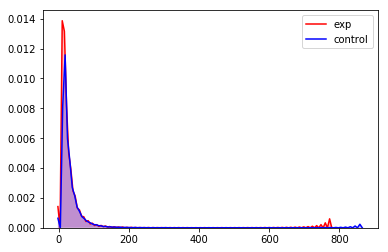

In [11]:
import seaborn as sns
sns.kdeplot(df[df.slot == 'exp']['n_clicks'], shade=True, color="r", label="exp")
sns.kdeplot(df[df.slot == 'control']['n_clicks'], shade=True, color="b", label="control")

In [12]:
np.random.seed(0)
n_boot_samples = 500
samples = get_bootstrap_samples(df[df.slot == 'control']['n_clicks'].values, n_boot_samples)

In [13]:
samples.shape

(500, 284554)

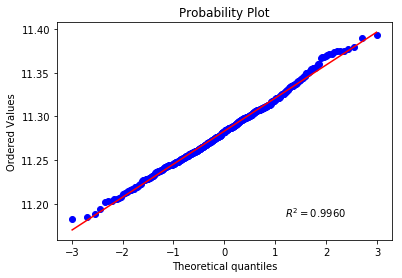

In [14]:
control_boot_mean = list(map(np.mean, samples))
stats.probplot(control_boot_mean, plot=plt, rvalue=True)
plt.show()

In [15]:
n = len(df[df.slot == 'control']['n_clicks'].values)
n

284554

In [16]:
control_boot_chi_squared = list(map(np.var, samples))

In [40]:
#control_boot_chi_squared = n * control_boot_chi_squared

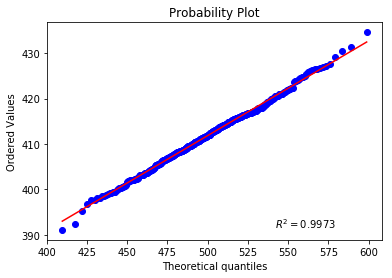

In [21]:
stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n_boot_samples-1), plot=plt, rvalue=True)
plt.show()

In [1]:
def iter_bootstrap_samples(data, n_samples):
    i = 0
    while i < n_samples:
        indices = np.random.randint(0, len(data), len(data))
        sample = data[indices]
        yield sample
        i += 1

In [32]:
control_clicks = df[df.slot == 'control'].loc[:,['userID', 'n_clicks']].groupby(['userID']).sum()

In [33]:
exp_clicks = df[df.slot == 'exp'].loc[:,['userID', 'n_clicks']].groupby(['userID']).sum()

In [46]:
stats.mannwhitneyu(control_clicks, exp_clicks).pvalue

4.3471471887604393e-75

In [37]:
np.mean(control_clicks)

n_clicks    11.287332
dtype: float64

In [38]:
np.mean(exp_clicks)

n_clicks    11.589352
dtype: float64

In [44]:
browser_list = list(df.browser.value_counts().index)
group_list = list(df.slot.value_counts().index)

In [55]:
global p_list
p_list = []
for browser in browser_list:
        control_clicks = df[(df.slot == 'control') & (df.browser == browser)].loc[:,['userID', 'n_clicks']].groupby(['userID']).sum()
        exp_clicks = df[(df.slot == 'exp') & (df.browser == browser)].loc[:,['userID', 'n_clicks']].groupby(['userID']).sum()
        p_list.append([browser, stats.mannwhitneyu(control_clicks, exp_clicks).pvalue])
mw_test = pd.DataFrame(p_list, columns = ['browser', 'p'])    
bon_holm = smm.multipletests(mw_test.p, alpha=0.05/2, method='holm')

In [57]:
bon_holm = pd.DataFrame(np.transpose(bon_holm[:2]), index = browser_list, columns = ['reject', 'p-corrected'])
bon_holm                                                               

,reject,p-corrected
Browser #4,0.0,0.815212
Browser #22,0.0,0.772217
Browser #2,0.0,0.136219
Browser #14,1.0,0.000000
Browser #20,0.0,0.815212
Browser #17,0.0,0.149602


In [58]:
mw_test

,browser,p
0,Browser #4,0.407606
1,Browser #22,0.257406
2,Browser #2,0.027244
3,Browser #14,0.000000
4,Browser #20,0.453667
5,Browser #17,0.037401


In [71]:
no_click_list = []
for slot in group_list:
    for browser in browser_list:
        new_df = df[(df.slot == slot) & (df.browser == browser)].loc[:,['n_nonclk_queries', 'n_queries']].sum()
        no_click_list.append([slot, browser, new_df['n_nonclk_queries']*100/new_df['n_queries']])
no_click_list        

[['control', 'Browser #4', 46.97092963514274],
 ['control', 'Browser #22', 40.593976593513354],
 ['control', 'Browser #2', 45.96274717919465],
 ['control', 'Browser #14', 57.59041136008114],
 ['control', 'Browser #20', 40.540484743383296],
 ['control', 'Browser #17', 36.29936674628209],
 ['exp', 'Browser #4', 45.14294190358467],
 ['exp', 'Browser #22', 39.85394721969546],
 ['exp', 'Browser #2', 44.982746948554706],
 ['exp', 'Browser #14', 43.755617361273295],
 ['exp', 'Browser #20', 38.97737648371716],
 ['exp', 'Browser #17', 36.93741284866483]]

In [60]:
tmp = df[(df.slot == 'exp') & (df.browser == 'Browser #4')].loc[:,['n_nonclk_queries', 'n_queries']].sum()

In [61]:
type(tmp)

pandas.core.series.Series

In [66]:
tmp.percent = tmp.n_nonclk_queries / tmp.n_queries

In [70]:
tmp['n_nonclk_queries']

456508